In [1]:
import os
import cv2
import tensorflow as tf
from imutils import paths
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Load the Data

In [2]:
#path to input dataset
datapath = r'C:\Users\Daniel Adama\Desktop\PROGRAMMING\1.3PythonDatascience\datascience\FaceDetection\dataset'

# Data Preprocessing

In [3]:
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras.preprocessing.image import ImageDataGenerator

#categories = os.listdir(datapath)
data = []
labels = []

pathToimages = list(paths.list_images(datapath))

for pathToimage in pathToimages:
    label = pathToimage.split(os.path.sep)[-2]
    #load the input image as (224x224) and preprocess it
    image = load_img(pathToimage, target_size=(224,224))
    image = img_to_array(image)
    image = preprocess_input(image)
    
    data.append(image)
    labels.append(label)


#convert the data and label to Numpy arrays
data = np.array(data, dtype='float32')
labels = np.array(labels)

#one-hot encoding the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

print(data.shape)
print(labels.shape)

(2020, 224, 224, 3)
(2020, 2)


In [4]:
#split the data into 80% training and 20% testing
(train_data, test_data, train_labels, test_labels) = train_test_split(data,labels,test_size=0.2,
                                                                      stratify=labels,random_state=42)

#construct the training image generator for data augmentation
datagen = ImageDataGenerator(rotation_range=20,
                            zoom_range=0.15,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            shear_range=0.15,
                            horizontal_flip=True,
                            fill_mode='nearest')
datagen.fit(train_data)

# Transfer Learning

In [5]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

#load the MobileNetV2 network
baseModel = MobileNetV2(weights='imagenet', #load pre-trained weights on imagenet
                       include_top=False, #making sure the top layer is left off
                       input_tensor=Input(shape=(224,224, 3)))

#construct the head of the model that will be placed on top of the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7,7))(headModel)
headModel = Flatten(name='flatten')(headModel)
headModel = Dense(320, activation='relu')(headModel) 
headModel = Dropout(0.4)(headModel)
headModel = Dense(2, activation='softmax')(headModel) #output layer

#place the head model on top of the base model (this becomes the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

#loop over all layers in the base model so they will not be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

In [6]:
print('Compiling the model'+'...'*5)
INIT_lr = 0.0001 #initialize learning rate
num_epoch = 30 #number of epochs to train for

#optimizer
opt = tf.keras.optimizers.Adam(INIT_lr)
model.compile(loss="binary_crossentropy",optimizer=opt,
              metrics=['accuracy'])

Compiling the model...............


In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

__________________________________________________________________________________________________
block_15_expand_BN (BatchNormal (None, 7, 7, 960)    3840        block_15_expand[0][0]            
__________________________________________________________________________________________________
block_15_expand_relu (ReLU)     (None, 7, 7, 960)    0           block_15_expand_BN[0][0]         
__________________________________________________________________________________________________
block_15_depthwise (DepthwiseCo (None, 7, 7, 960)    8640        block_15_expand_relu[0][0]       
__________________________________________________________________________________________________
block_15_depthwise_BN (BatchNor (None, 7, 7, 960)    3840        block_15_depthwise[0][0]         
__________________________________________________________________________________________________
block_15_depthwise_relu (ReLU)  (None, 7, 7, 960)    0           block_15_depthwise_BN[0][0]      
__________

In [8]:
#train the head model(which is the actual model now)
print('Training Model'+'...'*5)
BS=50

# remove the double slash// and leave it as one slash/
History = model.fit(datagen.flow(train_data, train_labels, batch_size=BS),
                                 steps_per_epoch=len(train_data) / BS,
                                 validation_data=(test_data, test_labels),
                                 validation_steps=len(test_data) / BS,epochs=num_epoch)

Training Model...............
Epoch 1/30
32/32 [==============================] - 100s 3s/step - loss: 0.5760 - accuracy: 0.7599 - val_loss: 0.2365 - val_accuracy: 0.9431
Epoch 2/30
32/32 [==============================] - 94s 3s/step - loss: 0.2432 - accuracy: 0.9223 - val_loss: 0.1581 - val_accuracy: 0.9455
Epoch 3/30
32/32 [==============================] - 102s 3s/step - loss: 0.1632 - accuracy: 0.9460 - val_loss: 0.1344 - val_accuracy: 0.9455
Epoch 4/30
32/32 [==============================] - 99s 3s/step - loss: 0.1275 - accuracy: 0.9583 - val_loss: 0.1218 - val_accuracy: 0.9455
Epoch 5/30
32/32 [==============================] - 101s 3s/step - loss: 0.1104 - accuracy: 0.9679 - val_loss: 0.1137 - val_accuracy: 0.9480
Epoch 6/30
32/32 [==============================] - 100s 3s/step - loss: 0.1084 - accuracy: 0.9592 - val_loss: 0.1045 - val_accuracy: 0.9530
Epoch 7/30
32/32 [==============================] - 99s 3s/step - loss: 0.1090 - accuracy: 0.9528 - val_loss: 0.0999 - val_acc

# Evaluate the Model

## Making Predictions on the testing set

In [14]:
pred_idx = model.predict(test_data, BS)

# for each image on the testing set we need to find the index of the label with the corresponding 
# largest predicted probability
pred_idx = np.argmax(pred_idx, axis=1)
print(classification_report(test_labels.argmax(axis=1), pred_idx, target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.95      0.98      0.97       199
without_mask       0.98      0.95      0.97       205

    accuracy                           0.97       404
   macro avg       0.97      0.97      0.97       404
weighted avg       0.97      0.97      0.97       404



In [15]:
print(model.evaluate(test_data,test_labels))

13/13 [==============================] - 15s 1s/step - loss: 0.0819 - accuracy: 0.9653
[0.0819258764386177, 0.9653465151786804]


In [19]:
model.save('face_mask_detector.model', save_format='h5')

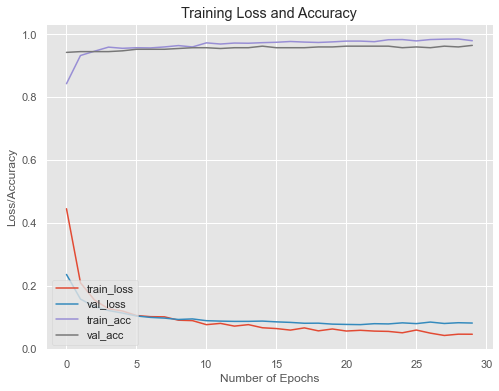

In [20]:
#plot the training loss and accuracy
N = num_epoch
plt.style.use("ggplot")
plt.figure(figsize=(8,6))
plt.plot(np.arange(0, N), History.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), History.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), History.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), History.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot")